In [1]:
    import os
    # Suppress TensorFlow C++ backend logs:
    #   '0' = all logs shown
    #   '1' = hide INFO messages
    #   '2' = hide INFO & WARNING messages
    #   '3' = hide INFO, WARNING, and only show ERROR
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    import warnings
    # Suppress Python warnings (e.g., DeprecationWarnings, UserWarnings)
    warnings.filterwarnings('ignore')
    
    import tensorflow as tf
    # Suppress TensorFlow Python-level logs as well (only show ERROR)
    tf.get_logger().setLevel('ERROR')

In [2]:
import os
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import sigma
from pycbc.types import FrequencySeries
from pycbc import noise, distributions
from gwpy.timeseries import TimeSeries
from tqdm import tqdm
from astropy import units as u

# ==============================
# === PARAMETERS AND SETTINGS ===
# ==============================
fs = 4096 # Sampling frequency (Hz)
duration = 4.0 # Length of each segment in seconds
delta_t = 1.0 / fs # Sampling interval
tsamples = int(fs * duration) # Number of time samples per segment
flow = 30.0 # Low-frequency cutoff for PSD (Hz)
target_snr_range = (8, 12) # Desired SNR range for injected signals

# Mass distribution: uniform between 10–50 solar masses for both components
mass_dist = distributions.Uniform(mass1=(10, 50), mass2=(10, 50))

# Possible injection times (relative to start of noise segment)
injection_times = [1.0, 1.5, 2.0, 2.5, 3.0]

# ==============================
# === DIRECTORY SETUP ===
# ==============================
base_dir = "./combined-dataset/"
dirs = {
    "real_noise": os.path.join(base_dir, "real-noise"),
    "real_signal_injected": os.path.join(base_dir, "real-signal-injected"),
    "real_signal": os.path.join((base_dir, "real-signal"),
    "synthetic_noise": os.path.join(base_dir, "synthetic-noise"),
    "synthetic_signal_injected": os.path.join(base_dir, "synthetic-signal-injected"),
    "synthetic_signal": os.path.join((base_dir, "synthetic-signal")
}

# Create directories if they don’t already exist
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# ==============================
# === LOAD REAL NOISE FILES ===
# ==============================
real_noise_dir = "./dataset/real-noise-files/"
# Collect all available real noise files (*.txt)
real_files = sorted([f for f in os.listdir(real_noise_dir) if f.endswith(".txt")])

# ==============================
# === PSD TEMPLATE (aLIGO) ===
# ==============================
# Frequency resolution
delta_f = 1.0 / duration
# Length of frequency bins up to Nyquist (2048 Hz)
flen = int(2048 / delta_f) + 1
# Load the aLIGO design sensitivity curve
psd_template = aLIGOZeroDetHighPower(flen, delta_f, flow)
# Replace zeros with tiny values to avoid division errors
psd_template[psd_template == 0] = 1e-40
# Wrap as a FrequencySeries
psd_template = FrequencySeries(psd_template, delta_f=delta_f)

# ============================================================
# === INJECT SIGNALS INTO REAL NOISE (using GWPy + PyCBC) ===
# ============================================================
for idx, file in tqdm(enumerate(real_files), total=len(real_files), desc="Real Noise Processing"):
    try:
        # --- Load and preprocess noise segment ---
        noise_path = os.path.join(real_noise_dir, file)
        noise_ts = TimeSeries.read(noise_path) # read real strain data
        # Apply taper, bandpass filter, and crop to fixed duration
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350).crop(noise_ts.t0.value, noise_ts.t0.value + duration)
        noise_pycbc = noise_ts.to_pycbc() # convert to PyCBC format

        # --- Generate random BBH signal parameters ---
        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2: # ensure m1 >= m2
            m1, m2 = m2, m1

        # Generate gravitational waveform (SEOBNRv2 approximant)
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))
        # --- Compute SNR of the signal ---
        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue # skip problematic signals
        
        # --- Rescale waveform to desired target SNR ---
        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr
        # --- Convert to GWPy and inject into noise ---
        signal_ts = TimeSeries.from_pycbc(hp)
        # Set signal start time relative to noise segment
        signal_ts.t0 = noise_ts.t0 + np.random.choice(injection_times) * u.second
        injected_ts = noise_ts.inject(signal_ts)
        # --- Save outputs ---
        noise_ts.write(os.path.join(dirs["real_noise"], f"real_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["real_signal"], f"real_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["real_signal_injected"], f"real_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Real [{idx}] skipped: {e}")

# ===============================================================
# === INJECT SIGNALS INTO SYNTHETIC NOISE (generated from PSD) ===
# ===============================================================
for idx in tqdm(range(len(real_files)), desc="Synthetic Noise Generation"):
    try:
        # --- Generate synthetic Gaussian noise from PSD ---
        noise_data = noise.noise_from_psd(tsamples, delta_t, psd_template)
        noise_ts = TimeSeries.from_pycbc(noise_data)
        noise_ts = noise_ts.taper('leftright', 0.5).bandpass(35, 350)
        # --- Generate random BBH signal ---
        m1, m2 = mass_dist.rvs(size=1)[0]
        if m1 < m2:
            m1, m2 = m2, m1
        hp, _ = get_td_waveform(approximant="SEOBNRv2", mass1=m1, mass2=m2, delta_t=delta_t, f_lower=40.0,
                                 distance=1, inclination=np.random.uniform(0, np.pi),
                                 spin1z=np.random.uniform(-0.99, 0.99),
                                 spin2z=np.random.uniform(-0.99, 0.99))
        # --- Compute SNR and rescale waveform ---
        ht = hp.to_frequencyseries()
        psd = aLIGOZeroDetHighPower(len(ht), ht.delta_f, flow)
        psd[psd == 0] = 1e-40
        psd = FrequencySeries(psd, delta_f=ht.delta_f)

        snr = sigma(ht, psd=psd, low_frequency_cutoff=40.0)
        if not np.isfinite(snr) or snr == 0:
            continue

        target_snr = np.random.uniform(*target_snr_range)
        hp *= target_snr / snr
        # --- Inject signal into synthetic noise ---
        signal_ts = TimeSeries.from_pycbc(hp)
        signal_ts.t0 = np.random.choice(injection_times)
        injected_ts = noise_ts.inject(signal_ts)
        # --- Save outputs ---
        noise_ts.write(os.path.join(dirs["synthetic_noise"], f"synthetic_noise_{idx}.txt"))
        signal_ts.write(os.path.join(dirs["synthetic_signal"], f"synthetic_signal_{idx}.txt"))
        injected_ts.write(os.path.join(dirs["synthetic_signal_injected"], f"synthetic_injected_{idx}.txt"))

    except Exception as e:
        print(f"⚠️ Synthetic [{idx}] skipped: {e}")


Synthetic Noise Generation: 100%|██████████| 4480/4480 [33:10<00:00,  2.25it/s]


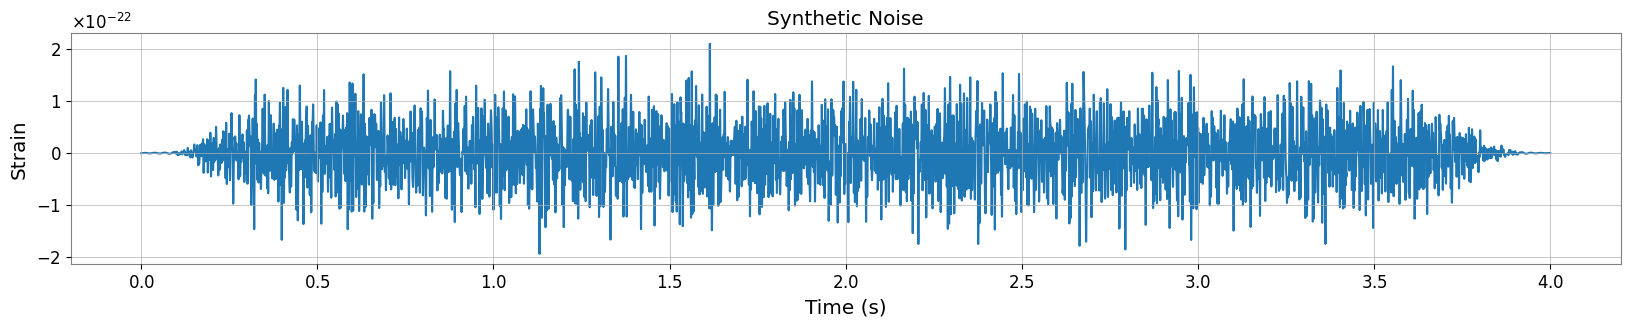

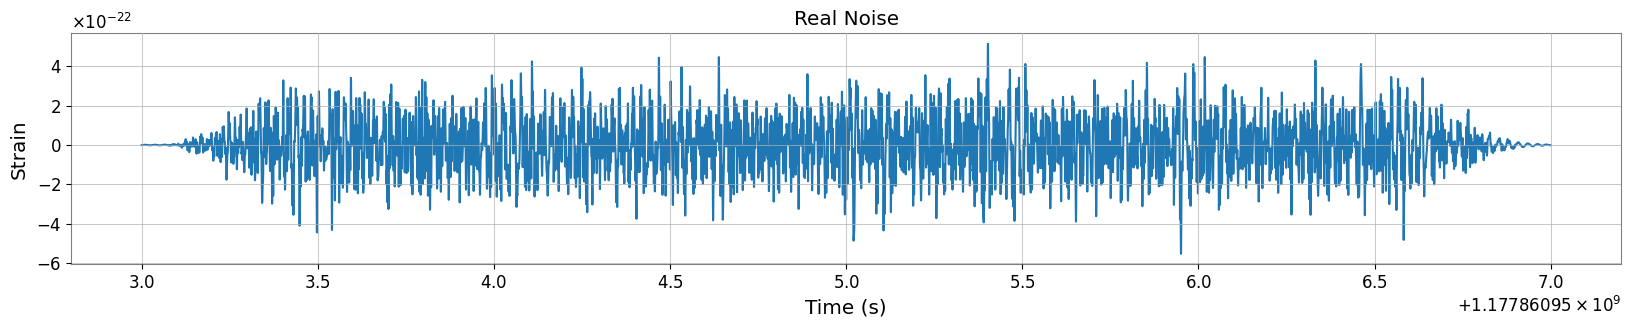

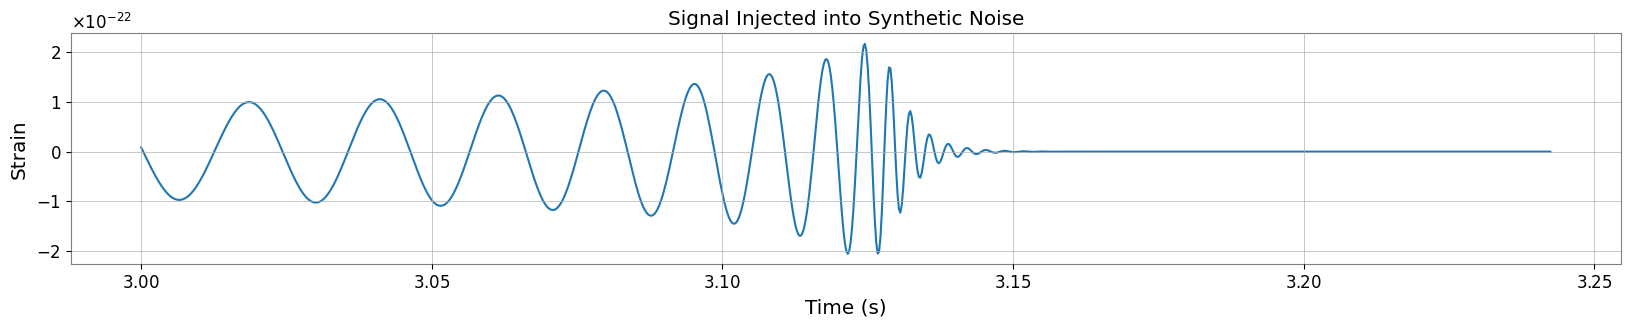

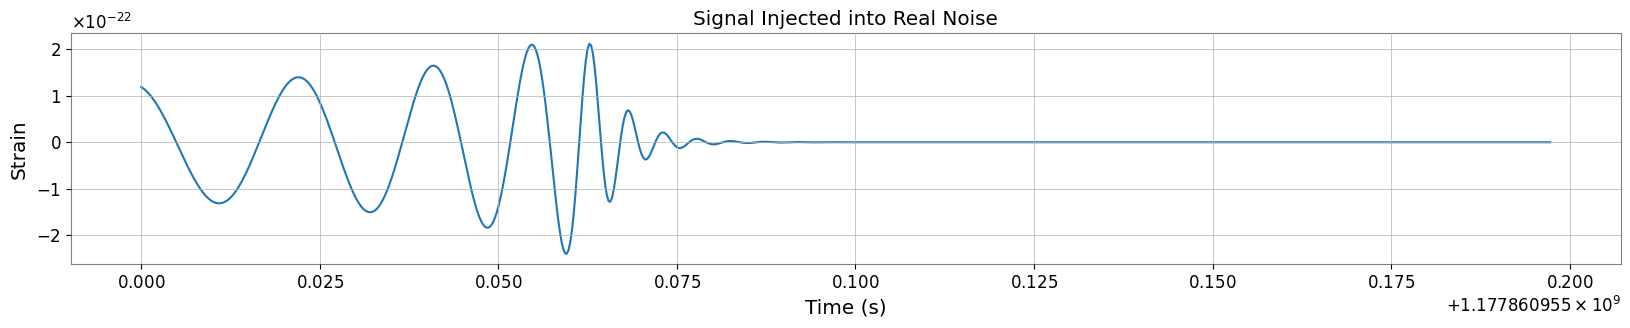

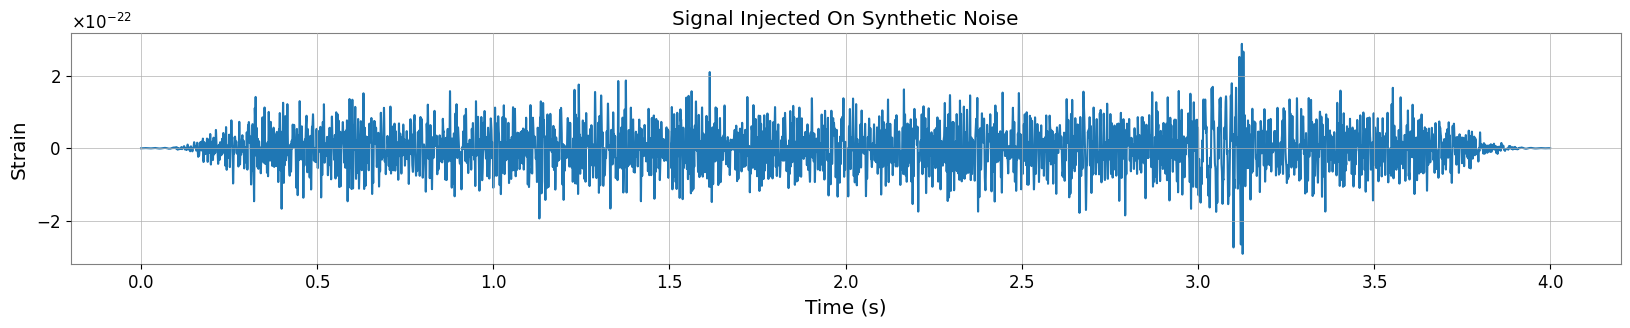

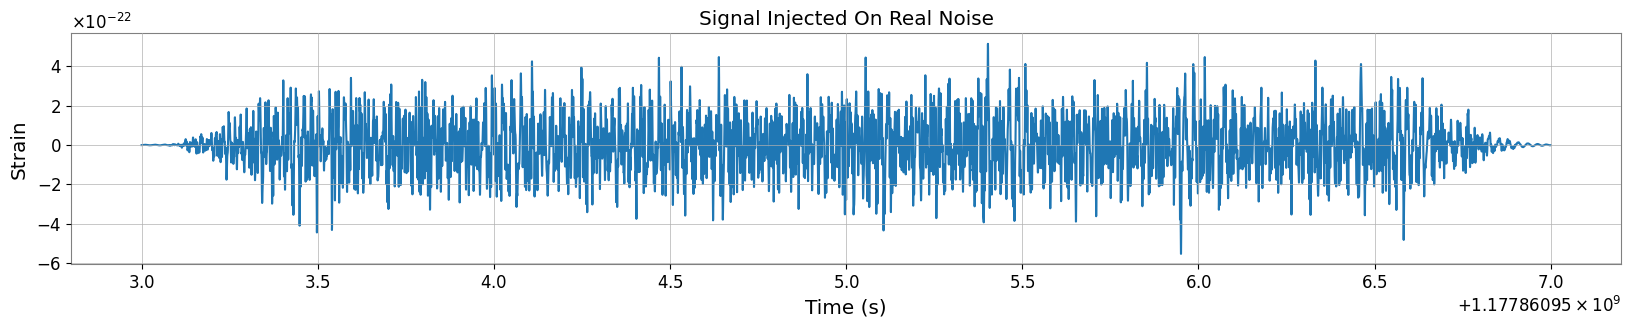

In [4]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries as GTimeSeries

# ==============================
# === PLOT SYNTHETIC NOISE ===
# ==============================
# Load synthetic noise time series
ts = GTimeSeries.read('./combined-dataset/synthetic-noise/synthetic_noise_5.txt')

# Plot synthetic noise waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Synthetic Noise")      # title for clarity
plt.xlabel("Time (s)")            # x-axis: time in seconds
plt.ylabel("Strain")              # y-axis: GW strain amplitude
plt.grid(True)                    # add grid for readability
plt.show()


# ==========================
# === PLOT REAL NOISE ===
# ==========================
# Load real noise time series
ts = GTimeSeries.read('./combined-dataset/real-noise/real_noise_5.txt')

# Plot real noise waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

# ======================================
# === PLOT SIGNAL ALONE (Synthetic) ===
# ======================================
# Load a pure signal (before injection) generated for synthetic noise
ts = GTimeSeries.read('./combined-dataset/synthetic-signal/synthetic_signal_5.txt')

# Plot signal-only waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected into Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

# ==================================
# === PLOT SIGNAL ALONE (Real) ===
# ==================================
# Load a pure signal (before injection) generated for real noise
ts = GTimeSeries.read('./combined-dataset/real-signal/real_signal_5.txt')

# Plot signal-only waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected into Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

# =====================================================
# === PLOT INJECTED SIGNAL (Synthetic Noise Segment) ===
# =====================================================
# Load synthetic noise with injected signal
ts = GTimeSeries.read('./combined-dataset/synthetic-signal-injected/synthetic_injected_5.txt')

# Plot combined signal+noise waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Synthetic Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

# =================================================
# === PLOT INJECTED SIGNAL (Real Noise Segment) ===
# =================================================
# Load real noise with injected signal
ts = GTimeSeries.read('./combined-dataset/real-signal-injected/real_injected_5.txt')

# Plot combined signal+noise waveform
plt.figure(figsize=(20, 3))
plt.plot(ts.times.value, ts.value)
plt.title("Signal Injected On Real Noise")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [5]:
import csv
import pandas as pd

In [6]:
#Merging the injected signal on real noise into single CSV file
path = "./combined-dataset/real-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/real-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [03:43<00:00, 20.07it/s]


In [7]:
#Merging the injected signal on synthetic noise into single CSV file
path = "./combined-dataset/synthetic-signal-injected/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-signal-injected.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [02:35<00:00, 28.80it/s]


In [8]:
#Merging the synthetic noise into single CSV file
path = "./combined-dataset/synthetic-noise/"
files= os.listdir(path)
f = open("./combined-dataset/synthetic-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [02:42<00:00, 27.54it/s]


In [9]:
#Merging the real noise into single CSV file
path = "./combined-dataset/real-noise/"
files= os.listdir(path)
f = open("./combined-dataset/real-noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 4480/4480 [02:59<00:00, 24.96it/s]
